<a href="https://colab.research.google.com/github/Coffinbrain/lessons/blob/main/21009200448%E4%BD%99%E6%98%95%E6%80%A1_%E5%AE%9E%E9%AA%8C%E4%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**21009200448余昕怡** 本次作业改写自李沐老师“动手学深度学习在线课程”中多层感知机一节的代码。原代码使用FashionMNIST数据集，本人新增基于MNIST及HWDB1的内容。

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-8e0cuq7j
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-8e0cuq7j
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


# 多层感知机的简洁实现
:label:`sec_mlp_concise`

本节将介绍(**通过高级API更简洁地实现多层感知机**)。


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## 模型

与softmax回归的简洁实现（ :numref:`sec_softmax_concise`）相比，
唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。
第一层是[**隐藏层**]，它(**包含256个隐藏单元，并使用了ReLU激活函数**)。
第二层是输出层。


In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

[**训练过程**]的实现与我们实现softmax回归时完全相同，
这种模块化设计使我们能够将与模型架构有关的内容独立出来。


In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

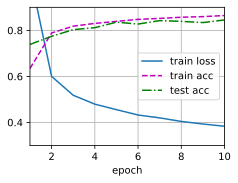

In [ ]:
#Fashion MNIST#
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

**21009200448余昕怡** MNIST部分改写自原代码中FashionMNIST（上个代码块）的内容。由于d2l文件中并未定义读取MNIST数据集的函数，本人仿照load_data_fashion_mnist()的格式进行了改编。

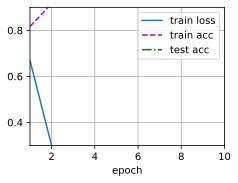

In [ ]:
#MNIST
import torchvision
from torch.utils import data
from torchvision import transforms
def get_dataloader_workers():
    """使用4个进程来读取数据

    Defined in :numref:`sec_fashion_mnist`"""
    return 4

def load_data_mnist(batch_size, resize=None):
    """下载MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

train_iter, test_iter = load_data_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**21009200448余昕怡** HWDB处理部分参考自https://github.com/Ruitao-chen/HWDB1-tensorflow2.0-lenet 算力不够，没实际跑过。


In [ ]:
from cProfile import label
from msilib.schema import Feature
import os
import numpy as np
import tensorflow as tf

def preprocess_image(image):
    image_size=28
    img_tensor = tf.image.decode_jpeg(image, channels=1)
    img_tensor = tf.image.resize(img_tensor, [image_size, image_size])
    img_tensor /= 255.0 # normalize to [0,1] range
    return img_tensor

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

def change_range(image,label):
    return 2*image-1, label

def get_HWDBdataset(dset):
    root_path = './DATA/HWDB1'
    BATCH_SIZE = 32
    images = []
    labels = []
    with open(os.path.join(root_path, dset+'.txt'), 'r') as f:
        for line in f:
            line = line.strip('\n')
            if line is not '':
                stringArray = line.split('\\')
                imgpath = stringArray[0] + '/' + stringArray[1] + '/' + stringArray[2]
                label = stringArray[1]
                images.append(imgpath)
                labels.append(int(label))
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)
    if dset == 'train':
        ds = image_label_ds.shuffle(buffer_size= len(images))
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        keras_ds = ds.map(change_range)
    else:
        ds = image_label_ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        keras_ds = ds.map(change_range)
    feature = []
    labels = []
    for index, lines in keras_ds:
        for i in index:
            feature.append(i)
        for j in lines:
            labels.append(j)
    feature = np.array(feature)
    labels = np.array(labels)
    return (feature, labels), int(np.ceil(len(images)/BATCH_SIZE))

In [ ]:
import tensorflow as tf
import numpy as np
from HWDB1 import *


(x_train,y_train)=next(iter(get_HWDBdataset('train')))
(x_test,y_test)=next(iter(get_HWDBdataset('test')))



model = net

#打印模型
print(model.summary())
#训练配置
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
#开始训练
model.fit(x=x_train, y=y_train, validation_split=0.2,
                        epochs=20, batch_size=300, verbose=2)

**21009200448余昕怡** 对不同数据集的操作如上，现只以FashionMNIST为例。以下是LeNet与AlexNet的实现。




In [ ]:
#LeNet
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
#AlexNet
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

[Discussions](https://discuss.d2l.ai/t/1802)
